In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor
from transformers import SegformerForSemanticSegmentation,SegformerConfig
#from evaluate import load as load_metric
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import wandb  # for logging
import matplotlib.pyplot as plt  # for plotting
import os
import rasterio
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
#import evaluate
# Initialize WandB in offline mode
#wandb.init(mode="offline")
os.environ["WANDB_MODE"] = "disabled"
from torch.utils.data import random_split

In [3]:
class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

class DualResize:
    def __init__(self, size):
        self.size = size
     

    def __call__(self, img, mask):
        return transforms.functional.resize(img, self.size), transforms.functional.resize(mask, self.size)

class DualToPILImage:
    def __call__(self, img, mask):
        return transforms.ToPILImage()(img), transforms.ToPILImage()(mask)

class DualRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            return transforms.functional.hflip(img), transforms.functional.hflip(mask)
        return img, mask

class DualRandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            return transforms.functional.vflip(img), transforms.functional.vflip(mask)
        return img, mask

class DualRandomRotation:
    def __init__(self, degrees):
   
        self.degrees = degrees

    def __call__(self, img, mask):
        #angle = transforms.RandomRotation.get_params(self.degrees)
        #angle = transforms.RandomRotation(10)
        angle=10
        #print(angle)
        return transforms.functional.rotate(img, angle), transforms.functional.rotate(mask, angle)

# class ImageColorJitter:
#     def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
#         self.transform = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

#     def __call__(self, img, mask):
#         return self.transform(img), mask
    
# class DualNormalize(object):
#     def __init__(self, mean, std):
#         self.mean = mean
#         self.std = std

#     def __call__(self, img, mask):
#         img = F.to_tensor(img)
#         img = transforms.functional.normalize(img, self.mean, self.std)
#         return img, mask

class DualNormalize:
    def __init__(self, mean, std, height_mean=0, height_std=1):
        """
        Args:
            mean: List of mean values for RGB channels.
            std: List of standard deviation values for RGB channels.
            height_mean: Mean value for the height channel.
            height_std: Standard deviation value for the height channel.
        """
        self.mean = mean
        self.std = std
        self.height_mean = height_mean
        self.height_std = height_std

    def __call__(self, img, mask):
        # Normalize RGB channels
        #print("typeeeeeeeeeeeee",type(img))
        #img = F.to_tensor(img)
        #img = torch.from_numpy(np.array(img).astype(np.float32))
        rgb_channels = img[:3, :, :]
        rgb_channels = transforms.functional.normalize(rgb_channels, self.mean, self.std)

        # Normalize height channel if it exists
        if img.shape[0] == 4:  # Check if the 4th channel exists
            height_channel = img[3, :, :]
            # Apply dataset-specific standardization
            height_channel = (height_channel - self.height_mean) / self.height_std
            img = torch.cat([rgb_channels, height_channel.unsqueeze(0)], dim=0)
        else:
            img = rgb_channels
        #print("image shape",img.shape)
        return img, mask

In [4]:
class InferCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

In [5]:
class InferNormalize:
    def __init__(self, mean, std, height_mean=0, height_std=1):
        """
        Args:
            mean: List of mean values for RGB channels.
            std: List of standard deviation values for RGB channels.
            height_mean: Mean value for the height channel.
            height_std: Standard deviation value for the height channel.
        """
        self.mean = mean
        self.std = std
        self.height_mean = height_mean
        self.height_std = height_std

    def __call__(self, img):
       
        rgb_channels = img[:3, :, :]
        rgb_channels = transforms.functional.normalize(rgb_channels, self.mean, self.std)

        # Normalize height channel if it exists
        if img.shape[0] == 4:  # Check if the 4th channel exists
            height_channel = img[3, :, :]
            # Apply dataset-specific standardization
            height_channel = (height_channel - self.height_mean) / self.height_std
            img = torch.cat([rgb_channels, height_channel.unsqueeze(0)], dim=0)
        else:
            img = rgb_channels
        #print("image shape",img.shape)
        return img

In [6]:
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std = [0.229, 0.224, 0.225]

imagenet_mean = [0.485, 0.456, 0.406]  
imagenet_std = [0.229, 0.224, 0.225] 
height_mean=2.06
height_std=3.9


#imagenet_mean_4ch = [0.485, 0.456, 0.406]  # Replace with the mean values for your dataset
#imagenet_std_4ch = [0.229, 0.224, 0.225]  # Replace with the std values for your dataset

# For training, we'll use augmentations
train_transform = DualCompose([
    DualToPILImage(),
    DualResize((512, 512)),  # Example size
    DualRandomHorizontalFlip(),
    DualRandomVerticalFlip(),
    DualRandomRotation(10),  # Example max rotation in degrees
    #ImageColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    DualNormalize(imagenet_mean, imagenet_std,height_mean,height_std),  # Added normalization
    #transforms.ToTensor()
])

# For training, we'll use augmentations
val_transform = DualCompose([
    DualToPILImage(),
    DualResize((512, 512)),  # Example size
    DualNormalize(imagenet_mean, imagenet_std,height_mean,height_std),  # Added normalization
    #transforms.ToTensor()
])

# For training, we'll use augmentations
transform = DualCompose([
    #DualToPILImage(),
    #DualResize((512, 512)),  # Example size
    DualNormalize(imagenet_mean, imagenet_std,height_mean,height_std),  # Added normalization
    #transforms.ToTensor()
])

In [7]:
# def normalize_to_range(data):
#     min_val=data.min()
#     max_val=data.max()
#     return (data-min_val)/(max_val-min_val)

In [8]:
# def normalize_to_range(data):
#     # Assume `data` has shape (C, H, W)
#     normalized_data = np.zeros_like(data, dtype=np.float32)
#     for c in range(data.shape[0]):  # Loop over channels
#         min_val = data[c].min()
#         max_val = data[c].max()
#         if max_val == min_val:
#             normalized_data[c] = np.zeros_like(data[c])  # Handle case where all values are the same
#         else:
#             normalized_data[c] = (data[c] - min_val) / (max_val - min_val)
#     return normalized_data *255

In [9]:
def normalize_to_range(data):
    """
    Normalize RGB channels to [0, 255] and process height channel separately.
    
    Args:
        data: Numpy array with shape (C, H, W) where C = 4 (R, G, B, Height).
        
    Returns:
        normalized_data: Numpy array with the same shape as `data`.
    """
    normalized_data = np.zeros_like(data, dtype=np.float32)
    for c in range(data.shape[0]):  # Loop over channels
        if c < 3:  # For RGB channels
            min_val = data[c].min()
            max_val = data[c].max()
            if max_val == min_val:
                normalized_data[c] = np.zeros_like(data[c])  # Handle case where all values are the same
            else:
                normalized_data[c] = (data[c] - min_val) / (max_val - min_val) 
                #normalized_data[c] = data[c]
        else:  # For the height channel
            height_channel = data[c]
            height_channel = np.clip(height_channel, a_min=0, a_max=None)  # Clip negative values to 0
            # max_val = height_channel.max()
            # if max_val > 0:
            #     normalized_data[c] = height_channel / max_val  # Scale to [0, 1]
            # else:
            normalized_data[c] = height_channel  # All zeros if max_val is 0
    return normalized_data

In [10]:
class_values = [0,1,2, 3, 4, 5,6,7,8,9,10] 
class_mapping = {val: idx for idx, val in enumerate(class_values)}

In [11]:
def remap_mask(mask, mapping):
    #print(mask)
    # Create a new array to hold the mapped values
    remapped_mask = np.zeros_like(mask)
    for original, mapped in mapping.items():
        remapped_mask[mask == original] = mapped
    return remapped_mask

In [12]:
import glob
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, mapping,processor, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        #self.image_filenames = os.listdir(image_dir)
        self.image_filenames = list(glob.glob(rf"{image_dir}\*.tif"))
        #self.mask_filenames = os.listdir(mask_dir)
        self.processor = processor
        self.transform = transform
        self.mapping = mapping

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        #print( self.image_filenames[idx])
        #image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, os.path.basename(image_path))
        #mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        # Use Rasterio to open the Geo-referenced image
        with rasterio.open(image_path) as src:
            bands=[1, 2, 3, 4]
            #bands=[1, 2, 3]
            #bands_data = src.read((4,3,2))
            bands_data = src.read(bands)
            #bands_data[3,:,:]=np.clip(bands_data[3,:,:],a_min=0,a_max=None)
            bands_data = bands_data.astype(np.float32) # Convert to float for the normalization

            # Normalize each band to [0, 1]
            bands_normalized = normalize_to_range(bands_data)

            # Rearrange bands into an RGB image
            #img_normalized = np.transpose(bands_normalized, [1, 2, 0])
            img_normalized = np.transpose(bands_normalized, [1, 2, 0])
            img_tensor=torch.from_numpy(img_normalized).permute(2,0,1)
        # Use Rasterio for masks too, assuming they are Geo-referenced as well
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # Read the mask as numpy array
            # Remap the mask
            mask = remap_mask(mask, self.mapping)
           
        original_image =img_tensor
        #original_segmentation_map =  torch.from_numpy(mask.copy())
        original_segmentation_map = torch.from_numpy(np.array(mask, dtype=np.int64))
        if self.transform is not None:
            img, mask = self.transform(img_tensor, mask)
             
            #img = F.to_tensor(img)
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        else:
            # Convert numpy arrays to PyTorch tensors
            #img = torch.from_numpy(img_tensor)
            img= img_tensor
            mask = torch.from_numpy(mask.copy())
        #print("hellllooooooooooooo",img.shape)

        # Process the image and mask using the MaskFormerImageProcessor
        #inputs = self.processor(images=img, segmentation_maps=mask, return_tensors="pt")
        return (img,mask,original_image, original_segmentation_map)
        #return inputs['pixel_values'].squeeze(0), inputs['segmentation_maps'].squeeze(0)


In [13]:
#from huggingface_hub import hf_hub_download
import json

repo_id = f"segments/sidewalk-semantic"
filename = "id2label.json"
with open(filename) as class_file:
  file_contents = class_file.read()
id2label = json.loads(file_contents)
#id2label = json.load(open(load_dataset(filename)))
id2label = {int(k):v for k,v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
print(id2label)

{0: 'bg', 1: 'banana', 2: 'coconut', 3: 'dragonfruit', 4: 'guava', 5: 'jackfruit', 6: 'mango', 7: 'sapota', 8: 'papaya', 9: 'othertrees', 10: 'arecanut'}


In [ ]:
from transformers import MaskFormerForInstanceSegmentation
import torch.nn as nn

# Load pre-trained SegFormer
model_name = "nvidia/mit-b4"
model = SegformerForSemanticSegmentation.from_pretrained(model_name,num_labels=11,id2label=id2label,label2id=label2id,local_files_only=True)

# Access the patch embeddings layer
original_in_channels = 3
new_in_channels = 4  # Example: RGB + Height + Roughness + Gradient
original_patch_embedding = model.segformer.encoder.patch_embeddings[0]

# Access the internal convolution layer
original_proj = original_patch_embedding.proj

# Get the number of output channels from the model configuration
out_channels = model.config.hidden_sizes[0]

# Create a new convolution layer with additional input channels
new_conv = nn.Conv2d(
    new_in_channels,
    out_channels,
    kernel_size=original_proj.kernel_size,
    stride=original_proj.stride,
    padding=original_proj.padding,
    bias=original_proj.bias is not None,
)

# Copy the weights from the original convolution layer for the first 3 channels
new_conv.weight.data[:, :original_in_channels, :, :] = original_proj.weight.data
# Initialize the weights for the new channels (e.g., random or mean of existing weights)
new_conv.weight.data[:, original_in_channels:, :, :] = original_proj.weight.data.mean(dim=1, keepdim=True)

# Replace the original convolution layer with the new one
original_patch_embedding.proj = new_conv

print("Modified model's patch embedding layer successfully.")
processor = SegformerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [14]:
processor = SegformerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

C:\Users\Admin\anaconda3\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'ignore_index'
  return func(*args, **kwargs)


In [ ]:
train_image_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/ITER_2/train/images'
train_label_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/ITER_2/train/masks'
val_image_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/ITER_2/val/images'
val_label_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/ITER_2/val/masks'
test_image_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/ITER_2/test/images'
test_label_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/ITER_2/test/masks'

# train_image_dir=r'D:\pvv\pvv\data\jack\train\images'
# train_label_dir=r'D:\pvv\pvv\data\jack\train\masks'
# val_image_dir=r'D:\pvv\pvv\data\jack\val\images'
# val_label_dir=r'D:\pvv\pvv\data\jack\val\masks'
#test_image_dir=r'D:\pvv\pvv\data\test\images'
#test_label_dir=r'D:\pvv\pvv\data\test\masks'

In [ ]:
train_image_dir=r'D:\pvv\pvv\data\train\images'
train_label_dir=r'D:\pvv\pvv\data\train\masks'
val_image_dir=r'D:\pvv\pvv\data\val\images'
val_label_dir=r'D:\pvv\pvv\data\val\masks'
test_image_dir=r'D:\pvv\pvv\data\test\images'
test_label_dir=r'D:\pvv\pvv\data\test\masks'

In [ ]:
train_image_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/8BIT/ITER_1/testing/train/images'
train_label_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/8BIT/ITER_1/testing/train/masks'
val_image_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/8BIT/ITER_1/testing/val/images'
val_label_dir='E:/PVV/DL-PROJECTS/HORTI/OBJ_2_SPECIES_DL_COMPARISON/DATA/TRAINING_SAMPLES/8BIT/ITER_1/testing/val/masks'

In [ ]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    #print(images)
    #print(images)
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    #print(images[0].dtype)
    
    batch = processor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
        input_data_format="channels_first"
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
 
    
    return batch

In [ ]:
# Load custom dataset
#image_dir = "path_to_images"
#mask_dir = "path_to_masks"
train_dataset = CustomDataset(image_dir=train_image_dir, mask_dir=train_label_dir,mapping=class_mapping,processor=processor, transform=transform)
val_dataset = CustomDataset(image_dir=val_image_dir, mask_dir=val_label_dir, mapping=class_mapping,processor=processor, transform=transform)

train_subset_size = 300
val_subset_size=60
train_subset, _ = random_split(train_dataset, [train_subset_size, len(train_dataset) - train_subset_size])
val_subset, _ = random_split(val_dataset, [val_subset_size, len(val_dataset) - val_subset_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,collate_fn=collate_fn)
#train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False,collate_fn=collate_fn)

In [ ]:
test_dataset = CustomDataset(image_dir=test_image_dir, mask_dir=test_label_dir, mapping=class_mapping,processor=processor, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,collate_fn=collate_fn)

In [ ]:
batch = next(iter(val_loader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

In [ ]:
print(len(batch["mask_labels"]))
print(len(batch["class_labels"]))

In [ ]:
print(batch["mask_labels"][0])
print(batch["class_labels"][0])

In [ ]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

In [ ]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

In [ ]:
np.unique(batch["mask_labels"][0])

In [ ]:
batch["mask_labels"][0]

In [ ]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  
  return Image.fromarray(visual_mask)

In [ ]:
visualize_mask(labels, "guava")

In [ ]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [ ]:
outputs.loss

In [ ]:
import evaluate

#metric = evaluate.load("mean_iou")

In [ ]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#metric = load_metric("mean_iou")
metric = evaluate.load("mean_iou")
#clf_metrics=evaluate.combine(["accuracy","f1","precision","recall"])
#optimizer = torch.optim.AdamW(model.parameters(), lr= 0.000392,weight_decay=4.3024e-05)
optimizer = torch.optim.AdamW(model.parameters(), lr= 3.97e-05,weight_decay=1.44e-06)

#running_loss = 0.0
running_train_loss = 0.0
running_val_loss = 0.0
num_tr_samples = 0
num_val_samples = 0
epoch_train_losses = []
epoch_val_losses = []
running_train_losses = []
running_val_losses = []
mean_ious = []
mean_accs=[]
accs=[]
num_epochs = 13
for epoch in range(num_epochs):
    print("Epoch:", epoch)
    epoch_train_loss = 0
    epoch_val_loss = 0
    model.train()
    for idx, batch in enumerate(tqdm(train_loader)):
        # Reset the parameter gradients
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
         # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        
        # Forward pass
        # outputs = model(
        #   pixel_values=batch["pixel_values"].to(device),
        #   mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        #   class_labels=[labels.to(device) for labels in batch["class_labels"]],
        # )
    
        # Backward propagation
        #loss = outputs.loss
        loss.backward()
    
        batch_size = batch["pixel_values"].size(0)
        running_train_loss += loss.item()
        epoch_train_loss+= loss.item()
        num_tr_samples += batch_size
        if idx % 100 == 0:
            print("Training Loss:", running_train_loss/num_tr_samples)
            running_train_losses.append(running_train_loss/num_tr_samples)
        # Optimization
        optimizer.step()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_losses.append(epoch_train_loss)

    model.eval()
    for idx, batch in enumerate(tqdm(val_loader)):
        # if idx > 5:
        #   break
    
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        with torch.no_grad():
          #outputs = model(pixel_values=pixel_values.to(device))
        #   outputs = model(
        #   pixel_values=batch["pixel_values"].to(device),
        #   mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        #   class_labels=[labels.to(device) for labels in batch["class_labels"]],
        # )
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
            #clf_metrics.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
            
            
        #loss = outputs.loss
        #print(loss)
        batch_size = batch["pixel_values"].size(0)
        running_val_loss += loss.item()
        epoch_val_loss+= loss.item()
        num_val_samples += batch_size
        if idx % 100 == 0:
            print("val Loss:", running_val_loss/num_val_samples)
            running_val_losses.append(running_val_loss/num_val_samples)
    
        
        # get original images
        #original_images = batch["original_images"]
        #target_sizes = [(image.shape[1], image.shape[2]) for image in original_images]
        #print("target size:",target_sizes)
        # predict segmentation maps
        #predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs,target_sizes=target_sizes)
        # get ground truth segmentation maps
        #ground_truth_segmentation_maps = batch["original_segmentation_maps"]
        #print("original mask shape",ground_truth_segmentation_maps[0].numpy().shape)
        #print("predicted mask shape",predicted_segmentation_maps[0].numpy().shape)
        #metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
    
    epoch_val_loss = epoch_val_loss / len(val_loader)
    epoch_val_losses.append(epoch_val_loss)
    final_score=metric.compute(num_labels = len(id2label), ignore_index = 0)
    #final_cls_score=clf_metrics.compute(num_labels = len(id2label), ignore_index = 0)
    mean_ious.append(final_score['mean_iou'])
    mean_accs.append(final_score['mean_accuracy'])
    #accs.append(final_cls_score['accuaracy'])
    print(f"Epoch {epoch+1} Mean IoU: {final_score['mean_iou']}")
    print(f"Epoch {epoch+1} Mean Accuracy: {final_score['mean_accuracy']}")
    #print(f"Epoch {epoch+1} Accuracy: {final_cls_score['accuracy']}")

    # NOTE this metric outputs a dict that also includes the mIoU per category as keys
    # so if you're interested, feel free to print them as well
    #print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

In [ ]:
 print(f"Epoch {epoch+1} classwise iou: {final_score['per_category_accuracy']}")

In [ ]:
# Plotting Loss and IoU curves
plt.figure(figsize=(12, 6))

# Plot training and validation loss curve
plt.plot(range(1, num_epochs + 1), epoch_train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), epoch_val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.tight_layout()
plt.savefig("../../../DATA/OUTPUT/SEGFORMER/RGBH/mit-b4/segformermitb4_epoch_train_val_losses_species_28-12-24.jpg", bbox_inches='tight',dpi=500)
plt.show()


# Plotting running Loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation loss curve
plt.plot(range(1, len(running_train_losses) + 1), running_train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(running_val_losses) + 1), running_val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.tight_layout()
plt.savefig("../../../DATA/OUTPUT/SEGFORMER/RGBH/mit-b4/segformermitb4_running_train_val_losses_species_28-12-24.jpg", bbox_inches='tight',dpi=500)
plt.show()

# Plotting Mean IoU curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), mean_ious, label='Mean IoU', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.title('Mean IoU Curve')
plt.legend()

plt.tight_layout()
plt.savefig("../../../DATA/OUTPUT/SEGFORMER/RGBH/mit-b4/IOUmitb4_plot_species_28-12-24.jpg", bbox_inches='tight',dpi=500)
plt.show()



In [ ]:
# Save model after fine-tuning
model.save_pretrained("../../../DATA/MODEL/FINAL/SEGFORMER/RGBH/segformer_mit-b4_uav_tree_species_28-12-24.pt")
#processor.save_pretrained("path_to_save_processor")

In [ ]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_loader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(val_loader)):
    if idx > 5:
      break

    pixel_values = batch["pixel_values"]
    
    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
  
  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

In [ ]:
image = Image.open('D:/pvv/pvv/data/val/images/iihr_2nd_pass_sub_areca_coco2_12_aug_5.TIF')
image

In [ ]:
#processor = SegformerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

# prepare the image for the model
#pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
#print(pixel_values.shape)
#pixel_values = batch["pixel_values"][0].to(device)

In [ ]:
batch = next(iter(test_loader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

In [ ]:
pixel_values = batch["pixel_values"][3][:3, :, :].numpy()
pixel_values.shape

In [ ]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [ ]:
original_images = batch["original_images"]
target_sizes = [(image.shape[1], image.shape[2]) for image in original_images]
# predict segmentation maps
#processor = MaskFormerImageProcessor(reduce_labels=False, do_resize=True, do_rescale=True, do_normalize=True)
#processor = MaskFormerImageProcessor(reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)
predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [ ]:
image = batch["original_images"][3]
Image.fromarray(image)

In [60]:
def color_palette():
    """Color palette that maps each class to RGB values.
    
    This one is actually taken from ADE20k.
    """
    return [[180, 180, 180], [191,255,0], [144,238,144], [255,0,255],
            [255,182,193], [128,128,0], [255,223,0], [210,180,140],
            [255,127,80], [0,255,255], [255,69,0]]

palette = color_palette()

[[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]


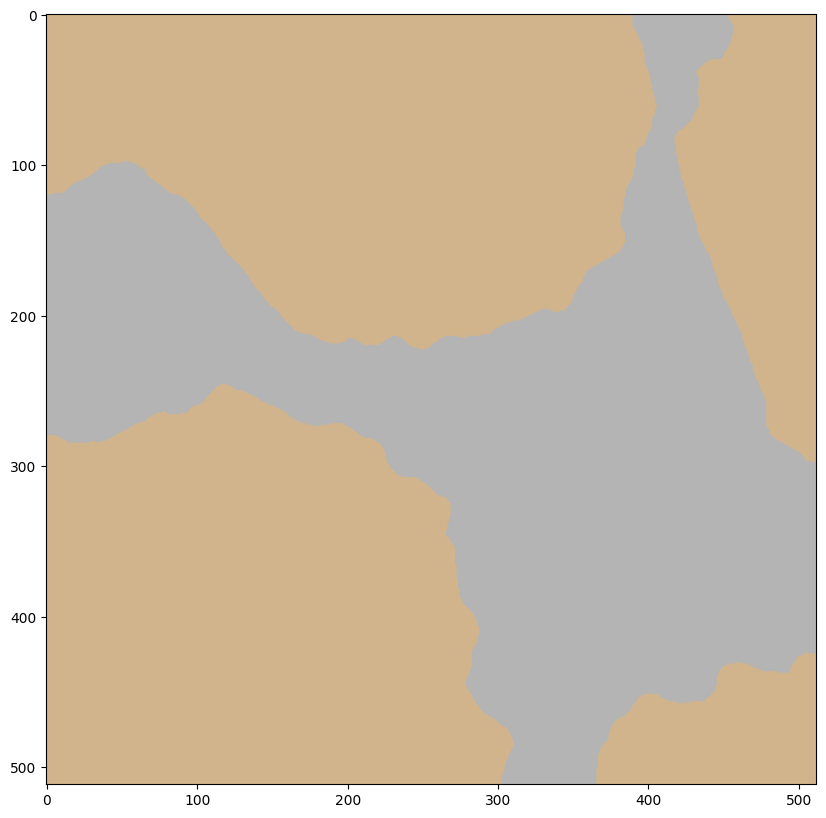

In [61]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()
print(segmentation_map)

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]
#image = np.transpose(image, [2, 1, 0])
#img = image * 0.5 + ground_truth_color_seg * 0.5
#img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(color_segmentation_map)
plt.savefig("../../../DATA/OUTPUT/SEGFORMER/RGBH/mit-b5/MODEL_OUTPUT_RGBH/pred_sapota_segformer_mit-b5-IIHR_TRAINING_SAMPLES_SAPOTA_144_aug_0.jpg", bbox_inches='tight',dpi=500)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][2]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

#img = image * 0.5 + ground_truth_color_seg * 0.5
#img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(segmentation_map)
plt.show()

In [ ]:
mean_accs

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def modify_patch_embedding(model, new_in_channels=4):
   # Load pre-trained SegFormer
   
    # Access the patch embedding layer
    original_in_channels = 3
    new_in_channels = 4  # Example: RGB + Height + Roughness + Gradient
    original_patch_embedding = model.segformer.encoder.patch_embeddings[0]
    
    # Access the internal convolution layer
    original_proj = original_patch_embedding.proj
    
    # Get the number of output channels from the model configuration
    out_channels = model.config.hidden_sizes[0]
    
    # Create a new convolution layer with additional input channels
    new_conv = nn.Conv2d(
        new_in_channels,
        out_channels,
        kernel_size=original_proj.kernel_size,
        stride=original_proj.stride,
        padding=original_proj.padding,
        bias=original_proj.bias is not None,
    )
    
    # Copy the weights from the original convolution layer for the first 3 channels
    new_conv.weight.data[:, :original_in_channels, :, :] = original_proj.weight.data
    # Initialize the weights for the new channels (e.g., random or mean of existing weights)
    new_conv.weight.data[:, original_in_channels:, :, :] = original_proj.weight.data.mean(dim=1, keepdim=True)
    
    # Replace the original convolution layer with the new one
    original_patch_embedding.proj = new_conv

# Load the configuration
model_dir="../../../DATA/MODEL/FINAL/SEGFORMER/RGBH/segformer_mit-b5_uav_tree_species_19-12-24.pt"
#model_dir = "maskformer_swin_base_ade_uav_tree_species.pt"
config = SegformerConfig.from_pretrained(model_dir, local_files_only=True)

# Instantiate the model (with a default architecture)
model = SegformerForSemanticSegmentation(config)

# Modify the architecture for 4-channel input
modify_patch_embedding(model)

# Load the safetensors state dictionary
from safetensors import safe_open

safetensors_path = f"{model_dir}/model.safetensors"
with safe_open(safetensors_path, framework="pt", device="cpu") as f:
    state_dict = {key: f.get_tensor(key) for key in f.keys()}

# Load the modified state dictionary into the model
model.load_state_dict(state_dict, strict=True)
model=model.to(device)
print("Successfully loaded the modified 4-channel MaskFormer model.")


Successfully loaded the modified 4-channel MaskFormer model.


In [17]:
processor = SegformerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

## Estimate model paprameters and memory for weights

In [ ]:
#from transformers import SegformerForSemanticSegmentation
#model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
memory_weights = total_params * 4 / (1024 ** 2)  # In MB for float32
print(f"Memory for Weights: {memory_weights:.2f} MB")

In [18]:
# For training, we'll use augmentations


import torch
import torchvision.transforms as transforms
from PIL import Image
#model_path = "../DATA/MODEL/species_model_unet_16-10-24.pt"
def predict(model, image_path, device):
    
    # transform = transforms.Compose([
    # transforms.Resize((512, 512)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    # For training, we'll use augmentations
    transform = InferCompose([
        InferNormalize(imagenet_mean, imagenet_std,height_mean,height_std),  # Added normalization
        #transforms.ToTensor()
        ])
    
    #image = Image.open(test_image_path).convert("RGB")
    
     # Use Rasterio to open the Geo-referenced image
    with rasterio.open(image_path) as src:
        
        bands=[1,2,3,4]
        #bands=[1,2,3]
        #bands = src.read((4,3,2))
        bands = src.read(bands)
        bands = bands.astype(np.float32) # Convert to float for the normalization

        # Normalize each band to [0, 1]
        bands_normalized = normalize_to_range(bands)

        # Rearrange bands into an RGB image
        img_normalized = np.transpose(bands_normalized, [1, 2, 0])
        img_tensor=torch.from_numpy(img_normalized).permute(2,0,1)    
        img_tensor = transform(img_tensor).unsqueeze(0).to(device) # Add batch dimension and move to device
    
    # Pass the preprocessed image through the model
    model.eval()
    with torch.no_grad():
        seg_output= model(img_tensor)
       
    
       
    return seg_output

In [58]:
test_image_path = "../../../DATA/TRAINING_SAMPLES/ITER_2/val/images/IIHR_TRAINING_SAMPLES_SAPOTA_144_aug_0.TIF"
test_mask_path = "../../../DATA/TRAINING_SAMPLES/ITER_2/val/masks/IIHR_TRAINING_SAMPLES_SAPOTA_144_aug_0.TIF"
predicted_mask = predict(model, test_image_path, device)

In [59]:
predicted_segmentation_maps = processor.post_process_semantic_segmentation(predicted_mask, target_sizes=[(512,512)])

In [ ]:
import torch
from tqdm.auto import tqdm
import evaluate
metric = evaluate.load("mean_iou")
f1_metric=evaluate.load("f1")
precision_metric=evaluate.load("precision")
recall_metric=evaluate.load("recall")

model.eval()
for idx, batch in enumerate(tqdm(test_loader)):
    # if idx > 5:
    #   break

    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
       
    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
       
        ground_truth_segmentation_maps = torch.cat(
            [gt_map.flatten() for gt_map in labels], dim=0
        ).cpu().numpy().astype('int32')
        
        predicted_segmentation_maps = torch.cat(
            [torch.tensor(pred_map).flatten() for pred_map in predicted], dim=0
        ).cpu().numpy().astype('int32')
        #print(type(ground_truth_segmentation_maps))
        #print(predicted_segmentation_maps)
        f1_metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
        precision_metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
        recall_metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

final_score=metric.compute(num_labels = len(id2label), ignore_index = 0)
final_f1_score=f1_metric.compute(average=None)
#mean_f1_score=f1_metric.compute(average="macro")
final_precision_score=precision_metric.compute(average=None)
#mean_precision_score=precision_metric.compute(average="macro")
final_recall_score=recall_metric.compute(average=None)
#mean_recall_score=precision_metric.compute(average="macro")
#final_cls_score=clf_metrics.compute(num_labels = len(id2label), ignore_index = 0)
#mean_ious.append(final_score['mean_iou'])
#mean_accs.append(final_score['mean_accuracy'])
#accs.append(final_cls_score['accuaracy'])
print(f"Mean IoU: {final_score['mean_iou']}")
print(f"Mean Accuracy: {final_score['mean_accuracy']}")
print(f"Classwise iou: {final_score['per_category_iou']}")
print(f"Classwise accuracy: {final_score['per_category_accuracy']}")
print(f"Classwise F1: {final_f1_score['f1']}")
print(f"Mean F1 score: {final_f1_score['f1'].mean()}")
print(f"Classwise Precision: {final_precision_score['precision']}")
print(f"Mean Precision score: {final_precision_score['precision'].mean()}")
print(f"Classwise Recall: {final_recall_score['recall']}")
print(f"Mean Recall score: {final_recall_score['recall'].mean()}")
#final_score['per_category_accuracy']}")

In [ ]:
import time
from tqdm.auto import tqdm
total_time = 0
model.eval()
for idx, batch in enumerate(tqdm(test_loader)):
    # if idx > 5:
    #   break

    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    #labels = batch["mask_labels"]
    
    # Forward pass
    with torch.no_grad():
        # Start timing
        start_time = time.time()
        outputs = model(pixel_values=pixel_values, labels=labels)
        torch.cuda.synchronize()  # Wait for GPU operations to complete
        end_time = time.time()

        total_time += (end_time - start_time)

print(f"Total Inference Time: {total_time:.2f} seconds")


In [ ]:
print(f"Average Latency per Batch: {total_time / len(test_loader):.2f} seconds")

## Per-Sample Latency: Compute the average time per sample:

In [ ]:
num_samples = len(test_dataset)
avg_latency = total_time / num_samples
print(f"Average Latency per Sample: {avg_latency * 1000:.2f} ms")